In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

# 1) Letterbox 함수 (원본 종횡비 유지 + 500×500에 패딩 적용)
def letterbox_image(img, desired_size=500, color=(0, 0, 0)):
    """
    img: 원본 이미지 (H x W x C)
    desired_size: 최종으로 만들고자 하는 정사각형 크기(기본 500×500)
    color: 패딩 영역에 채울 색상(BGR), 기본값은 검정색
    """
    old_height, old_width = img.shape[:2]

    # 더 긴 변을 desired_size에 맞춰 리사이즈 비율 계산
    ratio = float(desired_size) / max(old_width, old_height)

    # 종횡비 유지하며 리사이즈
    new_width = int(old_width * ratio)
    new_height = int(old_height * ratio)
    resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 패딩할 픽셀 수 계산
    delta_w = desired_size - new_width
    delta_h = desired_size - new_height
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left

    # 테두리(패딩) 추가
    letterboxed = cv2.copyMakeBorder(
        resized, 
        top, 
        bottom, 
        left, 
        right, 
        borderType=cv2.BORDER_CONSTANT,
        value=color  # (B,G,R) 검정색
    )

    return letterboxed

# 2) (이미지, 라벨) 쌍으로 불러오는 함수
def load_images_with_label(folder_path, label, letterbox_size=500, final_size=128):
    """
    folder_path 내 모든 이미지를 읽어:
      1) Letterbox(500×500) 적용 후,
      2) 최종적으로 128×128로 리사이즈
    (이미지, 라벨) 쌍 리스트로 반환
    """
    data = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path)  # 컬러(BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                # (1) Letterbox 적용 (500×500 + 검정색 패딩)
                letterboxed = letterbox_image(img, desired_size=letterbox_size, color=(0,0,0))
                # (2) 최종 128×128로 리사이즈
                final_resized = cv2.resize(letterboxed, (final_size, final_size), interpolation=cv2.INTER_AREA)
                data.append((final_resized, label))
    return data

# 3) 실제 폴더 경로 설정
masked = "/Users/coldbrew/Documents/SKT_FLY/2주차/data/face_maskdetection/with_mask"
unmasked = "/Users/coldbrew/Documents/SKT_FLY/2주차/data/face_maskdetection/without_mask"

# 4) 각각의 폴더에서 이미지 불러오기 (Letterbox=500, 최종=128)
masked_img = load_images_with_label(masked, 0, letterbox_size=500, final_size=128)
unmasked_img = load_images_with_label(unmasked, 1, letterbox_size=500, final_size=128)

# 5) 전체 데이터셋 합치고 섞기(shuffle)
dataset = masked_img + unmasked_img
dataset = shuffle(dataset)

print("데이터셋 크기:", len(dataset))
print("예시 (첫 번째 샘플) 이미지 shape:", dataset[0][0].shape)  # (128, 128, 3)
print("예시 (첫 번째 샘플) 라벨:", dataset[0][1])

데이터셋 크기: 1376
예시 (첫 번째 샘플) 이미지 shape: (128, 128, 3)
예시 (첫 번째 샘플) 라벨: 0


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# 섞기 (shuffle)
dataset = shuffle(dataset, random_state=42)

# X, y 분리
X = [item[0] for item in dataset]  # 이미지
y = [item[1] for item in dataset]  # 라벨

# 넘파이 배열로 변환
X = np.array(X)  # shape: (N, height, width, channels)
y = np.array(y)  # shape: (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)

# 픽셀값을 [0,1] 범위로 정규화 (이미 float이면 skip 가능)
X = X.astype('float32') / 255.0

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
print("학습 세트 크기:", X_train.shape, y_train.shape)
print("테스트 세트 크기:", X_test.shape, y_test.shape)

X shape: (1376, 128, 128, 3)
y shape: (1376,)
학습 세트 크기: (1100, 128, 128, 3) (1100,)
테스트 세트 크기: (276, 128, 128, 3) (276,)


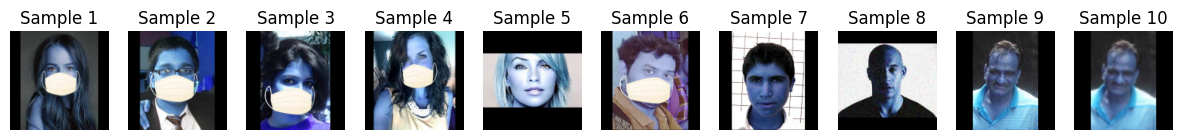

In [3]:
import cv2

import matplotlib.pyplot as plt

# 시각화할 이미지 개수
num_images = 10

plt.figure(figsize=(15, 15))
for i in range(num_images):
    sample_img = X[i]  # shape: (height, width, 3) (BGR)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(sample_img_rgb)
    plt.title(f"Sample {i+1}")
    plt.axis('off')

plt.show()

In [4]:
X[0].shape

(128, 128, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')  # 마스크/노마스크 2개 클래스
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print( model.summary() )
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,162 (3.42 MB)

 Trainable params: 896,162 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5195 - loss: 2.0277 - val_accuracy: 0.4409 - val_loss: 0.7115
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5207 - loss: 0.7134 - val_accuracy: 0.4409 - val_loss: 0.7452
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5127 - loss: 0.7410 - val_accuracy: 0.5727 - val_loss: 0.6815
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5572 - loss: 0.6769 - val_accuracy: 0.6273 - val_loss: 0.6722
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6258 - loss: 0.6567 - val_accuracy: 0.7045 - val_loss: 0.6569
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6902 - loss: 0.6210 - val_accuracy: 0.7591 - val_loss: 0.5730
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7510 - loss: 0.5184 - val_accuracy: 0.8545 - val_loss: 0.3945
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8476 - loss: 0.3712 - val_accuracy: 0.927

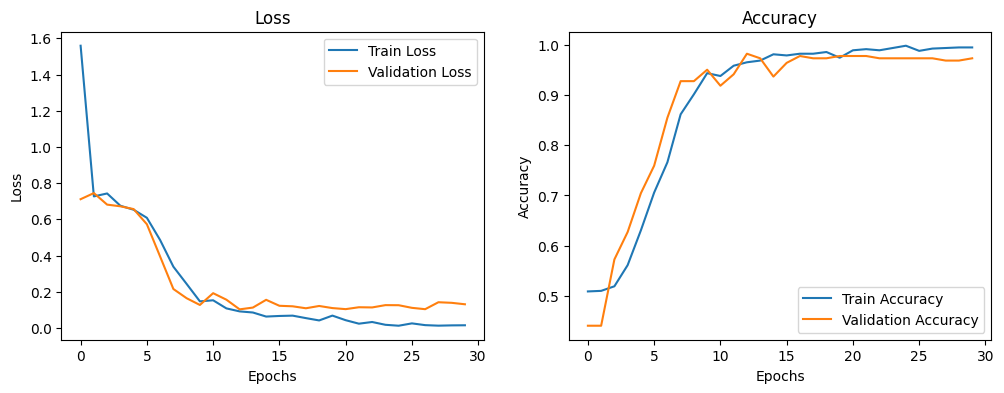

In [17]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습 및 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9739 - loss: 0.1093


[0.09341839700937271, 0.9746376872062683]

In [19]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# import os
# import cv2
# import numpy as np
# import pandas as pd

# w_mask_folder = "/content/drive/MyDrive/face_maskdetection/with_mask"
# wo_mask_folder = "/content/drive/MyDrive/face_maskdetection/without_mask"

# images = []
# labels = []

# for folder, label in [(w_mask_folder, 0), (wo_mask_folder, 1)]:
#     for filename in os.listdir(folder):
#         img_path = os.path.join(folder, filename)
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR) #BGR
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (128, 128))
#         images.append(img)
#         labels.append(label)

# images = np.array(images)
# labels = np.array(labels)
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# #데이터정규화
# X_train, X_test = X_train / 255.0, X_test / 255.0